<a href="https://colab.research.google.com/github/marcelounb/BB/blob/master/ia_mobile_TF_many_categories_final1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import files
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
path = "/content/fulldataset.xlsx"

In [4]:
dataset = pd.read_excel(path, sheet_name=0, header=0, dtype={'score': np.int32})

responsavel       = dataset[dataset.columns[0]].tolist()   # Responsável
natureza          = dataset[dataset.columns[1]].tolist()   # Natureza
classificacao     = dataset[dataset.columns[2]].tolist()   # Classificação
produtos_servicos = dataset[dataset.columns[3]].tolist()   # Produtos/Serviços
detalhamento      = dataset[dataset.columns[4]].tolist()   # Detalhamento
review            = dataset[dataset.columns[15]].tolist()  # review
score             = dataset[dataset.columns[16]].tolist()  # score

In [5]:
dataset.columns

Index(['Responsável', 'Natureza', 'Classificação', 'Produtos/Serviços',
       'Detalhamento', 'Descrição do Problema', 'Produtos/Serviços 2',
       'Detalhamento 2', 'Descrição do Problema 2', 'Produtos/Serviços 3',
       'Detalhamento 3', 'Descrição do Problema 3', 'id', 'userName',
       'userImage', 'review', 'score', 'thumbsUpCount', 'appVersion', 'date',
       'reply', 'replyDate'],
      dtype='object')

# Reduzindo o texto (retirando artigos, pontuacao e conjuncao 'e')

In [6]:
def reduzir_texto(frases):
  frase = ''
  for item in frases.lower().split():
    if item not in ['a', 'o', 'as', 'os', 'da', 'do', 'das', 'dos', 'e']:  # retira os artigos e conjuncao 'e'
      if item[-1] in ['.', ',', '!', ';' ]:
        frase +=str(item[0:-1])+' '  # retira pontuacao
      else:
        frase +=str(item)+' '

  return frase[:-1]

In [7]:
review_reduzida = []
for item in review:
  review_reduzida.append(reduzir_texto(item))
print(review[0:5])
print(review_reduzida[0:5])

['Excelente', 'Muito bom', 'Não estou conseguindo fazer um cartão de crédito para mim Eu só quero Aff já tentei várias vezes fazer o cartão quando eu fui fazer mandou esperar treis dias aí quando eu fui abri o aplicativo para ver se foi aprovado , Táva mandando fazer tudo dinovo', 'Por mais que eu tente não consigo desbloquear o app para transferências', 'Bom aplicativo eu gosto']
['excelente', 'muito bom', 'não estou conseguindo fazer um cartão de crédito para mim eu só quero aff já tentei várias vezes fazer cartão quando eu fui fazer mandou esperar treis dias aí quando eu fui abri aplicativo para ver se foi aprovado  táva mandando fazer tudo dinovo', 'por mais que eu tente não consigo desbloquear app para transferências', 'bom aplicativo eu gosto']


# Separando as bases de treinamento e de testes

In [8]:
# Separate out the sentences and labels into training and test sets
training_size = int(len(review) * 0.8)

training_sentences = review_reduzida[0:training_size]
testing_sentences = review_reduzida[training_size:]
training_labels = classificacao[0:training_size]
testing_labels = classificacao[training_size:]

In [9]:
# Tokenizing classificacao
tokenizer = Tokenizer()
tokenizer.fit_on_texts(classificacao)
word_index = tokenizer.word_index
print(word_index)
prediction_classes = word_index
reversed_prediction_classes = {value : key[0].upper() + key[1:] for (key, value) in prediction_classes.items()}
print(reversed_prediction_classes)

{'elogio': 1, 'reclamação': 2, 'crítica': 3, 'neutra': 4, 'dúvida': 5, 'sugestão': 6, 'resposta': 7, 'solicitação': 8}
{1: 'Elogio', 2: 'Reclamação', 3: 'Crítica', 4: 'Neutra', 5: 'Dúvida', 6: 'Sugestão', 7: 'Resposta', 8: 'Solicitação'}


In [10]:
len(word_index)
tamanho_classes = len(word_index)+1

In [11]:
def transforming_labels(lista):
  temp = []
  for item in lista:
    temp.append(word_index.get(item.lower()))
  return temp

In [12]:
training_labels = transforming_labels(training_labels)
testing_labels = transforming_labels(testing_labels)
training_labels[0:20]

[1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 3, 2, 2, 1, 2]

In [13]:
# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)
training_labels_final

array([1, 1, 2, ..., 1, 1, 1])

In [14]:
print(training_sentences[0:5])
print(training_labels[0:20], testing_labels[0:20])

['excelente', 'muito bom', 'não estou conseguindo fazer um cartão de crédito para mim eu só quero aff já tentei várias vezes fazer cartão quando eu fui fazer mandou esperar treis dias aí quando eu fui abri aplicativo para ver se foi aprovado  táva mandando fazer tudo dinovo', 'por mais que eu tente não consigo desbloquear app para transferências', 'bom aplicativo eu gosto']
[1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 3, 2, 2, 1, 2] [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2]


# Tokenize the dataset
Tokenize the dataset, including padding and OOV

In [15]:
vocab_size = 1000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, padding=padding_type, 
                       truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length, 
                               padding=padding_type, truncating=trunc_type)

# Review a Sequence
Let's quickly take a look at one of the padded sequences to ensure everything above worked appropriately.

In [16]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, 'x') for i in text])

print(decode_review(padded[0]))
print(training_sentences[0])

excelente x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x
excelente


# Train a Basic Sentiment Model with Embeddings

In [17]:
# Build a basic sentiment network
# Note the embedding layer is first, 
# and the output is only 1 node as it is either 0 or 1 (negative or positive)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(50, activation='relu', input_shape=(100,)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(tamanho_classes, activation='softmax')
])


# model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'] )
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           16000     
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               160100    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 4

In [18]:
num_epochs = 4
hist = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/4
2065/2065 [==============================] - 9s 4ms/step - loss: 0.2293 - accuracy: 0.9364 - val_loss: 0.1889 - val_accuracy: 0.9442
Epoch 2/4
2065/2065 [==============================] - 9s 4ms/step - loss: 0.1681 - accuracy: 0.9481 - val_loss: 0.1797 - val_accuracy: 0.9471
Epoch 3/4
2065/2065 [==============================] - 9s 4ms/step - loss: 0.1424 - accuracy: 0.9536 - val_loss: 0.1935 - val_accuracy: 0.9453
Epoch 4/4
2065/2065 [==============================] - 10s 5ms/step - loss: 0.1168 - accuracy: 0.9618 - val_loss: 0.1985 - val_accuracy: 0.9441


In [19]:
scores = model.evaluate(testing_padded, testing_labels_final, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
print(hist.history.keys())

Baseline Error: 5.59%
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


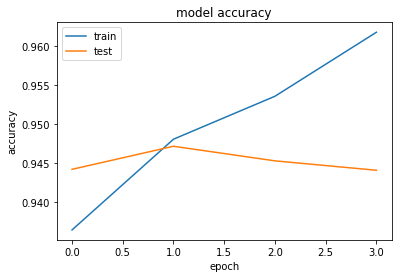

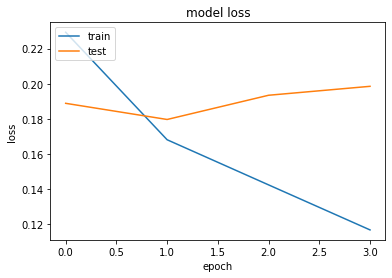

In [20]:
plt.plot(hist.history[ 'accuracy' ])
plt.plot(hist.history[ 'val_accuracy' ])
plt.title( 'model accuracy' )
plt.ylabel( 'accuracy')
plt.xlabel( 'epoch' )
plt.legend([ 'train' , 'test' ], loc= 'upper left' )
plt.show()
# summarize history for loss
plt.plot(hist.history[ 'loss' ])
plt.plot(hist.history[ 'val_loss' ])
plt.title( 'model loss' )
plt.ylabel( 'loss' )
plt.xlabel( 'epoch' )
plt.legend([ 'train' , 'test' ], loc= 'upper left' )
plt.show()

# Novas Predições:

In [21]:
path = "/content/predicao-arquivo-novo.xlsx"

In [22]:
dataset = pd.read_excel(path, sheet_name=0, header=0, dtype={'score': np.int32})

responsavel       = dataset[dataset.columns[0]].tolist()   # Responsável
natureza          = dataset[dataset.columns[1]].tolist()   # Natureza
classificacao     = dataset[dataset.columns[2]].tolist()   # Classificação
produtos_servicos = dataset[dataset.columns[3]].tolist()   # Produtos/Serviços
detalhamento      = dataset[dataset.columns[4]].tolist()   # Detalhamento
review            = dataset[dataset.columns[15]].tolist()  # review
score             = dataset[dataset.columns[16]].tolist()  # score

In [23]:
# Use the model to predict a review   
new_reviews = review

print(new_reviews) 

# Create the sequences
padding_type='post'
sample_sequences = tokenizer.texts_to_sequences(new_reviews)
fakes_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_length)           

print('\nHOT OFF THE PRESS! HERE ARE SOME NEWLY MINTED, ABSOLUTELY GENUINE REVIEWS!\n')              

classes = model.predict(fakes_padded)

print(new_reviews[17])
print(classes[15:17])

['Sensacional adorei', 'Faço absolutamente tudo pelo App.\nRápido e eficiente. 👏', 'Consigo fazer praticamente tudo sem ter que precisar do atendimento dentro do Banco.', 'Excelente', 'Aplicativo pratico e sem defeitos!', 'Excelente produto, obrigado.', 'Obg Banco do Brasil por ser esse banco incrível...', 'Excelente app!', 'O app é muito prático. Ajuda muito para eu não perder tempo com serviços bancários. Muito bom!', 'Muito bom ter um App tão seguro e tão ágil, simples para qualquer idade!', 'Melhor app de banco que existe', 'Excelente gerenciador financeiro. Parabéns aos desenvolvedores.', 'Bom aplicativo. Cumpre o que é esperado pelo cliente.', 'Eu solicitei o cartão de crédito, enviei todos os documentos, fui aprovado mas na hora de escolher o melhor cartão pra mim não vai, só aparece QUERO ESSE mas não vai nem aparece a foto do cartão.', 'Mto bom pq eh prático, simples e atende as necessidades básicas do dia a dia', 'Apos desinstalar o app e instalar novamente ele não pede mais 

In [24]:
classes_list = classes.tolist()
for contagem in range(15):
  print(contagem, classes_list[contagem].index(np.max(classes[contagem], axis=0, keepdims=True)))

0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 2
14 1


In [25]:
print(reversed_prediction_classes)
print(reversed_prediction_classes[2])

{1: 'Elogio', 2: 'Reclamação', 3: 'Crítica', 4: 'Neutra', 5: 'Dúvida', 6: 'Sugestão', 7: 'Resposta', 8: 'Solicitação'}
Reclamação


In [26]:
lista_predicao = []
for item in classes_list:
  lista_predicao.append(reversed_prediction_classes[item.index(max(item))])
lista_predicao[10:20]

['Elogio',
 'Elogio',
 'Elogio',
 'Reclamação',
 'Elogio',
 'Reclamação',
 'Reclamação',
 'Elogio',
 'Elogio',
 'Elogio']

In [27]:
dataset[dataset.columns[2]] = lista_predicao
dataset.head(3)

,Responsável,Natureza,Classificação,Produtos/Serviço 1,Detalhamento 1,Problema 1,Produtos/Serviço 12,Detalhamento 12,Problema 2,Produtos/Serviço 13,Detalhamento 3,Problema 3,id,userName,title,review,rating,thumbsUpCount,version,date,reply,replyDate
0,Automático,Opinião,Elogio,Aplicativo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6302065085,Dudu chamba,Perfeito,Sensacional adorei,5,NaN,7.26.4,2020-08-10 08:14:41,NaN,NaT
1,Automático,Opinião,Elogio,Aplicativo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6302063114,IzaMMR,Excelente e confiável,Faço absolutamente tudo pelo App.\nRápido e ef...,5,NaN,7.26.4,2020-08-10 08:13:56,NaN,NaT
2,Automático,Negocial,Elogio,Aplicativo,Usabilidade,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6302056613,Dayanne wendy(ronald),Muito bom,Consigo fazer praticamente tudo sem ter que pr...,5,NaN,7.26.4,2020-08-10 08:11:34,NaN,NaT


# Salvando o arquivo em Excel

In [28]:
writer = pd.ExcelWriter("novo_arquivo_predicao_gerada.xlsx")
dataset.to_excel(writer, index=False)
writer.save()